In [22]:
import wandb
import matplotlib.pyplot as plt

In [23]:
api = wandb.Api()

ENTITY = "cormaccureton-mcgill-university"
PROJECT = "Decomp"

In [24]:
plt.rcParams.update({'font.size': 18})

In [25]:
runs = api.runs(f"{ENTITY}/{PROJECT}")

In [26]:
report_runs = []
for run in runs:
    if len(run.tags) > 0 and run.tags[0] == "final-results":
        report_runs.append(run)

print(f"Found {len(report_runs)} report runs")

Found 36 report runs


In [27]:
# Group runs by name into a dictionary
runs_by_name = {}
for run in report_runs:
    if run.name not in runs_by_name:
        runs_by_name[run.name] = []
    runs_by_name[run.name].append(run)

print(f"Found {len(runs_by_name)} unique runs")

Found 12 unique runs


In [28]:
# Calculate the average and standard deviation of the runs' accuracies
average_runs = {}
std_runs = {}
for name, runs in runs_by_name.items():
    avg = {}
    std = {}
    for run in runs:
        for key, val in run.summary.items():
            if "accuracy" in key:
                if key not in avg:
                    avg[key] = 0
                    std[key] = 0
                avg[key] += val
                std[key] += val ** 2
    for key in avg.keys():
        avg[key] /= len(runs)
        std[key] = (std[key] / len(runs) - avg[key] ** 2) ** 0.5
    average_runs[name] = avg
    std_runs[name] = std

In [29]:
print(f"Calculated averages and standard deviations")
print(average_runs)
print(std_runs)

Calculated averages and standard deviations
{'zebra-base-eval-zeroshot-1B': {'eval/partial_accuracy': 0.4375429349053291, 'eval/strict_accuracy': 0.0, 'eval_partial_accuracy': 0.4375429349053291, 'eval_strict_accuracy': 0.0}, 'zebra-base-eval-3shot-1B': {'eval/partial_accuracy': 0.49399841165985947, 'eval/strict_accuracy': 0.006666666666666667, 'eval_partial_accuracy': 0.49399841165985947, 'eval_strict_accuracy': 0.006666666666666667}, 'zebra-base-eval-zeroshot-3B': {'eval/partial_accuracy': 0.5526489050743989, 'eval/strict_accuracy': 0.023333333333333334, 'eval_partial_accuracy': 0.5526489050743989, 'eval_strict_accuracy': 0.023333333333333334}, 'zebra-base-eval-3shot-3B': {'eval/partial_accuracy': 0.6253524913695027, 'eval/strict_accuracy': 0.06999999999999999, 'eval_partial_accuracy': 0.6253524913695027, 'eval_strict_accuracy': 0.06999999999999999}, 'zebra-training-zeroshot-1B': {'eval/partial_accuracy': 0.5207472426912186, 'eval/strict_accuracy': 0.035, 'eval_partial_accuracy': 0.5

In [ ]:
# Can add in the SOS results here manually
# average_runs["SOS"] = { ...

In [46]:
def combine_avg_std(avg, std):
    combined = {}
    for key in avg.keys():
        combined[key] = (avg[key], std[key])
    return combined

In [50]:
# Split between zebra and sudoku
zebra_runs = {}
sudoku_runs = {}
for name, runs in average_runs.items():
    if "zebra" in name:
        zebra_runs[name] = combine_avg_std(runs, std_runs[name])
    else:
        sudoku_runs[name] = combine_avg_std(runs, std_runs[name])

In [51]:
print(zebra_runs.keys())

print(sudoku_runs.keys())

dict_keys(['zebra-base-eval-zeroshot-1B', 'zebra-base-eval-3shot-1B', 'zebra-base-eval-zeroshot-3B', 'zebra-base-eval-3shot-3B', 'zebra-training-zeroshot-1B', 'zebra-training-zeroshot-3B'])
dict_keys(['sudoku-base-eval-zeroshot-1B', 'sudoku-base-eval-3shot-1B', 'sudoku-base-eval-zeroshot-3B', 'sudoku-base-eval-3shot-3B', 'sudoku-training-zeroshot-3B', 'sudoku-training-zeroshot-1B'])


In [52]:
print(zebra_runs.values())

print(sudoku_runs.values())

dict_values([{'eval/partial_accuracy': (0.4375429349053291, 0.004396998776541963), 'eval/strict_accuracy': (0.0, 0.0), 'eval_partial_accuracy': (0.4375429349053291, 0.004396998776541963), 'eval_strict_accuracy': (0.0, 0.0)}, {'eval/partial_accuracy': (0.49399841165985947, 0.005449822356046041), 'eval/strict_accuracy': (0.006666666666666667, 0.002357022603955157), 'eval_partial_accuracy': (0.49399841165985947, 0.005449822356046041), 'eval_strict_accuracy': (0.006666666666666667, 0.002357022603955157)}, {'eval/partial_accuracy': (0.5526489050743989, 0.008268578085981346), 'eval/strict_accuracy': (0.023333333333333334, 0.0023570226039551514), 'eval_partial_accuracy': (0.5526489050743989, 0.008268578085981346), 'eval_strict_accuracy': (0.023333333333333334, 0.0023570226039551514)}, {'eval/partial_accuracy': (0.6253524913695027, 0.007289294034596861), 'eval/strict_accuracy': (0.06999999999999999, 0.01471960144387976), 'eval_partial_accuracy': (0.6253524913695027, 0.007289294034596861), 'eva

In [66]:
def plot_results(runs, key, title, ylabel):
    fig, ax = plt.subplots()
    bar_width = 0.1
    # make the plot larger
    fig.set_size_inches(8, 8)

    grouped_accuracies  = {
        'Base Model (Zero Shot)': {k: v for k, v in runs.items() if 'base-eval-zeroshot' in k},
        'Base Model (Three Shot)': {k: v for k, v in runs.items() if 'base-eval-3shot' in k},
        'SFT LoRA Model (Zero Shot)': {k: v for k, v in runs.items() if 'training-zeroshot' in k},
        # TODO: Include the SoS results once available
        # 'SoS LoRA Model (Zero Shot)': {k: v for k, v in runs.items() if 'lora_sos_zero_shot' in k},
        # 'SoS LoRA Model (Three Shot)': {k: v for k, v in runs.items() if 'lora_sos_three_shot' in k},
    }

    # Plot grouped bar chart
    labels = ['1B', '3B']
    offset = bar_width * (len(grouped_accuracies) - 1) / 2
    x = [1.5, 2.2]


    # Plot bars for each group
    for i, (group, accuracies) in enumerate(grouped_accuracies.items()):
        partial_accuracies = [entry[key][0] for entry in accuracies.values()]
        errors = [entry[key][1] for entry in accuracies.values()]
        ax.bar(x=[xi + i * bar_width for xi in x], height=partial_accuracies, width=0.1, label=group)
        ax.errorbar(x=[xi + i * bar_width for xi in x], y=partial_accuracies, yerr=errors, fmt='none', capsize=5,color='black')


    # Add labels and title
    ax.set_xlabel('Model Size')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks([xi + offset for xi in x])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper left')

    plt.show()

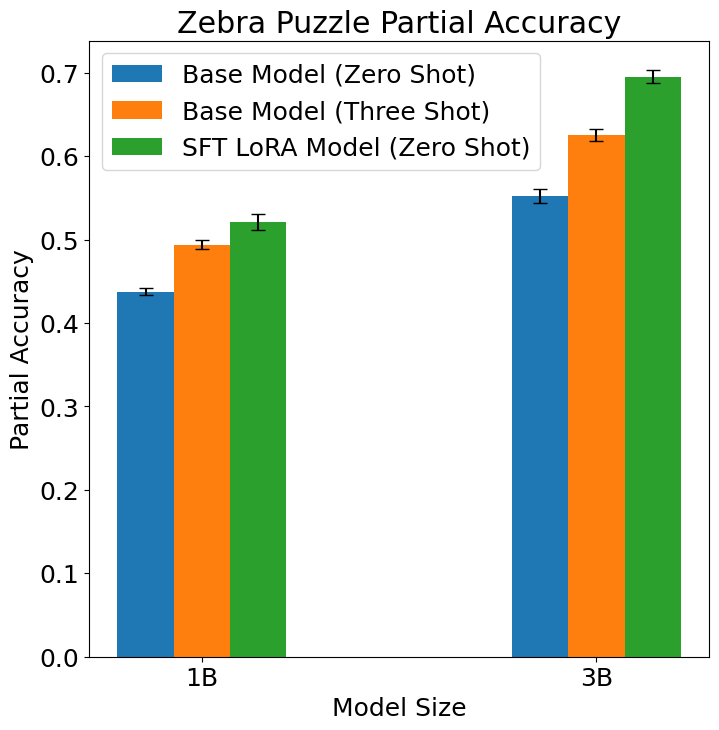

In [67]:
plot_results(zebra_runs, 'eval/partial_accuracy', 'Zebra Puzzle Partial Accuracy', 'Partial Accuracy')

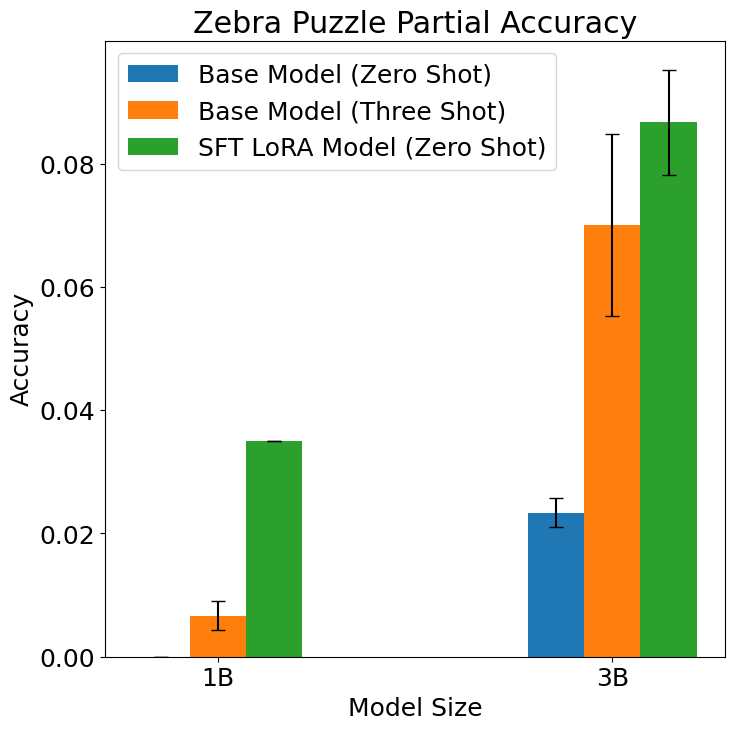

In [69]:
plot_results(zebra_runs, 'eval/strict_accuracy', 'Zebra Puzzle Partial Accuracy', 'Accuracy')

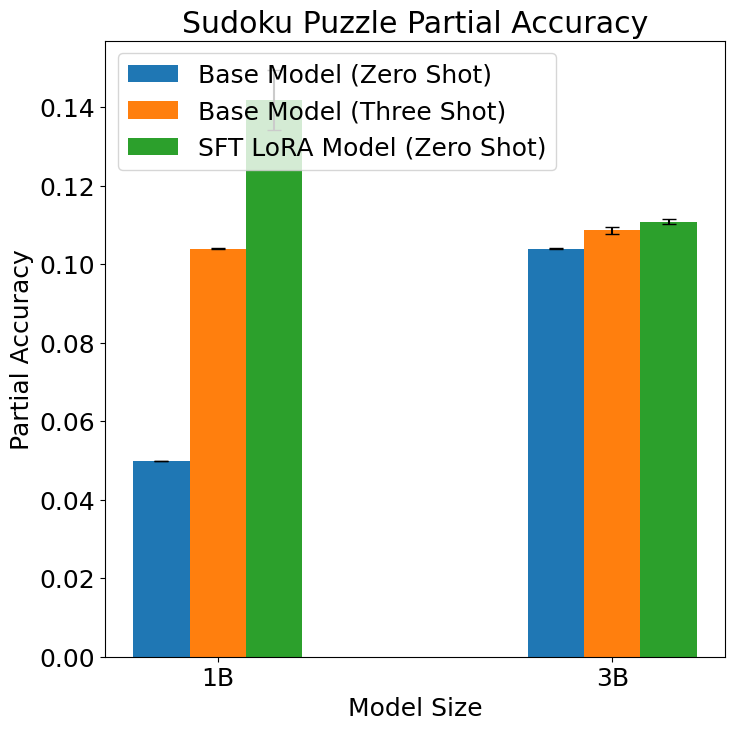

In [68]:
plot_results(sudoku_runs, 'eval/partial_accuracy', 'Sudoku Puzzle Partial Accuracy', 'Partial Accuracy')